_Neural Data Science_

Lecturer: Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Rita González Márquez, Fabio Seel

Summer term 2024

Names: Lalitha Sivakumar, Madhavi Sen, Kübra Ozdemir

# Coding Lab 6

In this exercise we are going to fit a latent variable model (Poisson GPFA) to both toy data and real data from monkey primary visual cortex.

## Preliminaries

### 1. Code 

The toolbox we are going to use contains an implementation of the EM algorithm to fit the poisson-gpfa. 

Assuming you `git clone https://github.com/berenslab/poisson-gpfa` to the parent directory and have the following directory structure:


```
├── data/
│   └── nds_cl_6_data.mat
├── poisson-gpfa/
├── notebooks
│   └── CodingLab6.ipynb
├── matplotlib_style.txt
├── requirements.txt
```

then you can import the related functions via:

```
import sys
sys.path.append('../poisson-gpfa/')
sys.path.append('../poisson-gpfa/funs')

import funs.util as util
import funs.engine as engine
```

Change the paths if you have different directory structure. For the details of the algorithm, please refer to the thesis `hooram_thesis.pdf` from ILIAS.

### 2. Data

Download the data file ```nds_cl_6_data.mat``` from ILIAS and save it in a ```data/``` folder.

In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

# style
import seaborn as sns

# poisson-gpfa
import sys

sys.path.append("../poisson-gpfa-master/")
sys.path.append("../poisson-gpfa-master/funs")

import funs.util as util
import funs.engine as engine

%matplotlib inline

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

Last updated: 2024-06-13 16:27:03W. Europe Daylight Time

Python implementation: CPython
Python version       : 3.9.2rc1
IPython version      : 8.18.1

sklearn: 1.5.0

matplotlib: 3.9.0
scipy     : 1.13.1
sys       : 3.9.2rc1 (tags/v3.9.2rc1:4064156, Feb 17 2021, 11:25:18) [MSC v.1928 64 bit (AMD64)]
numpy     : 1.26.4
seaborn   : 0.13.2

Watermark: 2.4.3



In [2]:
plt.style.use("../matplotlib_style.txt")

## Task 1. Generate some toy data to test the poisson-GPFA code

We start by verifying our code on toy data. The cell below contains code to generate data for 30 neurons, 100 trials (1000 ms each) and 50ms bin size. The neurons' firing rate $\lambda_k$ is assumed to be a constant $d_k$ modulated by a one-dimensional latent state $x$, which is drawn from a Gaussian process:

$\lambda_k = \exp(c_kx + d_k)$

Each neuron's weight $c_k$ is drawn randomly from a normal distribution and spike counts are sampled form a Poisson distribution with rate $\lambda_k$.

Your task is to fit a Poisson GPFA model with one latent variable to this data (see `engine.PPGPFAfit`).

Hint: You can use `util.dataset?`, `engine.PPGPFAfit?` or `util.initializeParams?` to find out more about the provided package.

*Grading: 3 pts*

In [3]:
# ---------------------------------
# simulate a training set (0.5 pts)
# ---------------------------------

# Initialize random number generator
np.random.seed(123)

# Specify dataset & fitting parameters
latent_dim = 1
observed_dim = 30
num_trials = 100
trial_duration_ms = 1000
bin_size_ms = 50
max_em_iterations = 100
firing_rate_offset = 1

# Sample from the model (make a toy dataset)
training_set = util.dataset(
    seed=np.random.randint(10000),
    xdim=latent_dim,
    ydim=observed_dim,
    numTrials=num_trials,
    trialDur=trial_duration_ms,
    binSize=bin_size_ms,
    dOffset=firing_rate_offset,
    fixTau=True,
    fixedTau=np.linspace(0.1, 0.5, latent_dim),
    drawSameX=True,
)

+------------- Simulated Dataset Options -------------+
                                                    1 | Dimensionality of Latent State
                                                   30 | Dimensionality of Observed State (# neurons)
                                                 1000 | Duration of trials (ms):
                                                   50 | Size of bins (ms):
                                                  100 | Number of Trials
+-----------------------------------------------------+
Sampling trial 100 ...
Average firing rate per neuron in this dataset: 23.709 Hz.


### Fit the model

In [4]:
# Initialize parameters using Poisson-PCA
init_params = util.initializeParams(latent_dim, observed_dim, training_set)

# Choose sensible parameters and run fit
fitToy = engine.PPGPFAfit(
    experiment=training_set,
    initParams=init_params,
    inferenceMethod="laplace",
    EMmode="Batch",
    maxEMiter=max_em_iterations,
)

Initializing parameters with Poisson-PCA..
+-------------------- Fit Options --------------------+
                                                    1 | Dimensionality of Latent State
                                                   30 | Dimensionality of Observed State (# neurons)
                                                Batch | EM mode:
                                                  100 | Max EM iterations:
                                              laplace | Inference Method
+-----------------------------------------------------+
Iteration: 100 of 100, nPLL: = -382.6751
This dataset is a simulated dataset.
Processing performance against ground truth parameters...


In [5]:
# some useful functions
def allTrialsState(fit: engine.PPGPFAfit, p) -> np.ndarray:
    """Reshape the latent signal and the spike counts"""
    x = np.zeros([p, 0])
    for i in range(len(fit.infRes["post_mean"])):
        x = np.concatenate((x, fit.infRes["post_mean"][i]), axis=1)
    return x


def allTrialsX(training_set: util.dataset) -> np.ndarray:
    """Reshape the ground truth
    latent signal and the spike counts"""
    x_gt = np.array([])
    for i in range(len(training_set.data)):
        x_gt = np.concatenate((x_gt, training_set.data[i]["X"][0]), axis=0)
    return x_gt

### Plot the ground truth vs. inferred model
Verify your fit by plotting both ground truth and inferred parameters for:
1. weights C
2. biases d
3. latent state x 

Note that the sign of fitted latent state and its weights are ambiguous (you can flip both without changing the model). Make sure you correct the sign for the plot if it does not match the ground truth.

In [6]:
# All trials latent state vector
x_est = allTrialsState(fitToy, 1)
x_true = allTrialsX(training_set)

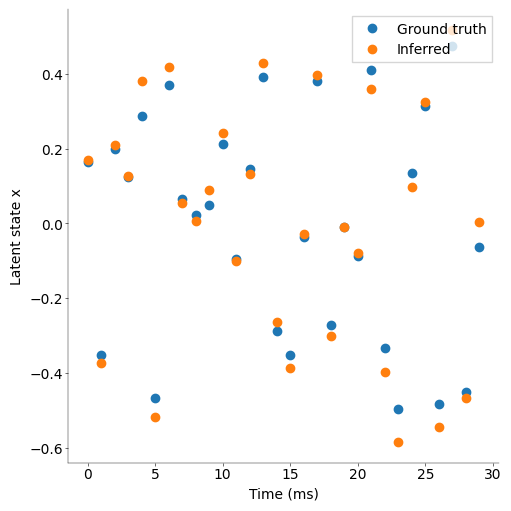

In [7]:
# ----------------------------------------------------
# Plot ground truth and inferred weights `C` (0.5 pts)
# ----------------------------------------------------

fig, ax = plt.subplots(figsize=(5, 5))
# add plot
# consider also plotting the optimal weights as a dotted line for reference

ax.plot(training_set.params["C"], "o", label="Ground truth")
ax.plot(-1 * fitToy.optimParams["C"], "o", label="Inferred")  # flip sign
ax.set_xlabel("Time (ms)")
ax.set_ylabel("Latent state x")
ax.legend(loc="upper right", frameon=True)
plt.show()

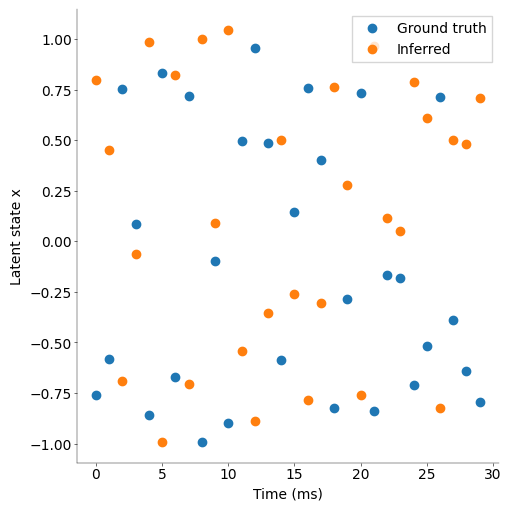

In [13]:
# ---------------------------------------------------
# Plot ground truth and inferred biases `d` (0.5 pts)
# ---------------------------------------------------

fig, ax = plt.subplots(figsize=(5, 5))
# add plot
# consider also plotting the optimal weights as a dotted line for reference

ax.plot(training_set.params["d"], "o", label="Ground truth")
ax.plot(-1 * fitToy.optimParams["d"], "o", label="Inferred")
ax.set_xlabel("Time (ms)")
ax.set_ylabel("Latent state x")
ax.legend(loc="upper right", frameon=True)
plt.show()

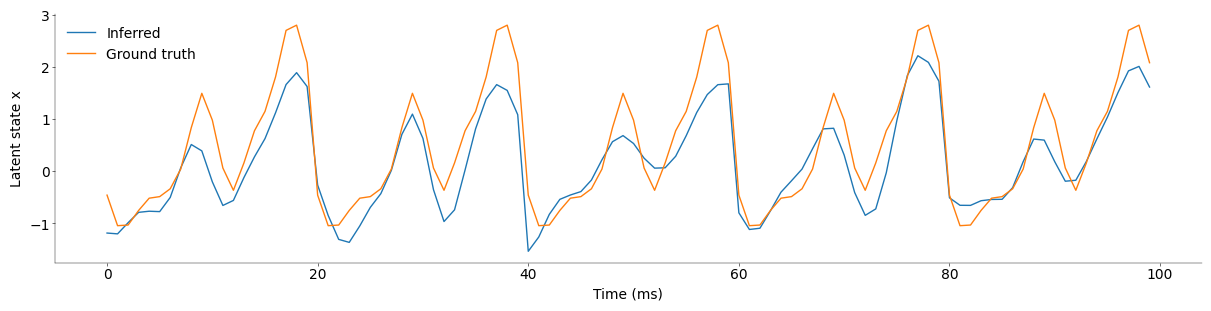

In [8]:
# ------------------------------------------------------
# Plot ground truth and inferred latent states `x` (1pt)
# ------------------------------------------------------

fig, ax = plt.subplots(figsize=(12, 3))
# add plot
# plot only for a subset of trials
# consider seperating each trial by a vertical line
ax.plot(x_est.flatten()[:100], label="Inferred")
ax.plot(-1 * x_true.flatten()[:100], label="Ground truth")
ax.set_xlabel("Time (ms)")
ax.set_ylabel("Latent state x")
ax.legend()

## Task 2: Fit GPFA model to real data. 

We now fit the model to real data and cross-validate over the dimensionality of the latent variable.

*Grading: 2 pts*



### Load data

The cell below implements loading the data and encapsulates it into a class that matches the interface of the Poisson GPFA engine. You don't need to do anything here.

In [9]:
class EckerDataset:
    """Loosy class"""

    def __init__(
        self,
        path: str,
        subject_id: int = 0,
        ydim: int = 55,
        trialDur: int = 2000,
        binSize: int = 100,
        numTrials: int = 100,
        ydimData: bool = False,
        numTrData: bool = True,
    ):
        # T = binSize #int(trialDur/binSize)
        T = int(trialDur / binSize)
        matdat = sio.loadmat(path)
        self.matdat = matdat
        data = []
        trial_durs = []
        for trial_id in range(numTrials):
            trial_time = matdat["spikeTimes"][:, trial_id][0]
            trial_big_time = np.min(trial_time)
            trial_end_time = np.max(trial_time)
            trial_durs.append(trial_end_time - trial_big_time)
        for trial_id in range(numTrials):
            Y = []
            spike_time = []
            data.append(
                {
                    "Y": matdat["spikeCounts"][:, :, trial_id],
                    "spike_time": matdat["spikeTimes"][:, trial_id],
                }
            )
        self.T = T
        self.trial_durs = trial_durs
        self.data = data
        self.trialDur = trialDur
        self.binSize = binSize
        self.numTrials = numTrials
        self.ydim = ydim
        util.dataset.getMeanAndVariance(self)
        util.dataset.getAvgFiringRate(self)
        util.dataset.getAllRaster(self)

In [10]:
path = "../data/nds_cl_6_data.mat"
data = EckerDataset(path)

### Fit Poisson GPFA models and perform model comparison

Split the data into 80 trials used for training and 20 trials held out for performing model comparison. On the training set, fit models using one to five latent variables. Compute the performance of each model on the held-out test set.

Hint: You can use the `crossValidation` function in the Poisson GPFA package.

Optional: The `crossValidation` function computes the sum of the squared errors (SSE) on the test set, which is not ideal. The predictive log-likelihood under the Poisson model would be a better measure, which you are welcome to compute instead.

### Derivation for log-likelihood

_You can add your calculations in_ $\LaTeX$ _here_.

$p_\lambda(x_t) = \frac{1}{\sqrt{2\pi\tau^2}} \exp\left(-\frac{(x_t - d_t)^2}{2\tau^2}\right)$

$L(\lambda_k; x_1, ..., x_N) = \prod_{t=1}^{N} p_{\lambda_k}(x_t)$ 

$\log(L) = l(\lambda_k; x_1, ..., x_N) = \sum_{t=1}^{N} \log\left(\frac{1}{\sqrt{2\pi\tau^2}} \exp\left(-\frac{(x_t - d_t)^2}{2\tau^2}\right)\right)$


In [11]:
# ------------------------------
# Perfom cross validation (1 pt)
# ------------------------------

# fit the model to the data

numtrain = 80
numtest = 20
xdim = 1  # number of modulators
initParams = util.initializeParams(xdim, data.ydim, data)
fitBatch = engine.PPGPFAfit(
    experiment=data,
    initParams=initParams,
    inferenceMethod="laplace",
    EMmode="Batch",
    maxEMiter=max_em_iterations,
)

Initializing parameters with Poisson-PCA..
+-------------------- Fit Options --------------------+
                                                    1 | Dimensionality of Latent State
                                                   55 | Dimensionality of Observed State (# neurons)
                                                Batch | EM mode:
                                                  100 | Max EM iterations:
                                              laplace | Inference Method
+-----------------------------------------------------+
Iteration: 100 of 100, nPLL: = -378.5838

In [12]:
# do the actual cross validation
xval = util.crossValidation(
    experiment=data,
    numTrainingTrials=numtrain,
    numTestTrials=numtest,
    inferenceMethod="laplace",
)

Assessing optimal latent dimensionality will take a long time.
Initializing parameters with Poisson-PCA..
+-------------------- Fit Options --------------------+
                                                    1 | Dimensionality of Latent State
                                                   55 | Dimensionality of Observed State (# neurons)
                                                Batch | EM mode:
                                                    3 | Max EM iterations:
                                              laplace | Inference Method
+-----------------------------------------------------+
Iteration:   3 of   3, nPLL: = -402.6497Performing leave-one-out cross validation...
Initializing parameters with Poisson-PCA..
+-------------------- Fit Options --------------------+
                                                    2 | Dimensionality of Latent State
                                                   55 | Dimensionality of Observed State (# neurons)
         

### Plot the test error

Make a plot of the test error for the five different models. As a baseline, please also include the test error of a model without a latent variable. This is essentially the SSE of a constant rate model (or Poisson likelihood if you did the optional part above).

baseline error:  4.490095867768595


Text(0, 0.5, 'test error')

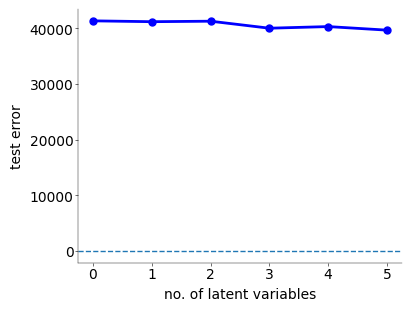

In [37]:
# -----------------------------------------------------------------------------------------
# Compute and plot the test errors for the different latent variable models (0.5 + 0.5 pts)
# -----------------------------------------------------------------------------------------

train_set, test_set = util.splitTrainingTestDataset(
    data, numTrainingTrials=80, numTestTrials=20
)
# compute baseline error
baseline_error = np.mean(
    np.square(test_set.data[0]["Y"] - np.mean(test_set.data[0]["Y"]))  # (y-yhat)**2
)
print("baseline error: ", baseline_error)


# plot
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(
    np.arange(0, xval.maxXdim), xval.errs, "b.-", markersize=10, linewidth=2
)  # model error
ax.axhline(baseline_error, linestyle="--")  # dashed baseline
ax.set_xlabel("no. of latent variables")
ax.set_ylabel("test error")

## Task 3. Visualization: population rasters and latent state. Use the model with a single latent state. 

Create a raster plot where you show for each trial the spikes of all neurons as well as the trajectory of the latent state `x` (take care of the correct time axis). Sort the neurons by their weights `c_k`. Plot only the first 20 trials.

*Grading: 2 pts*

C:\Users\madha\AppData\Local\Temp\ipykernel_15476\624722002.py:61: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


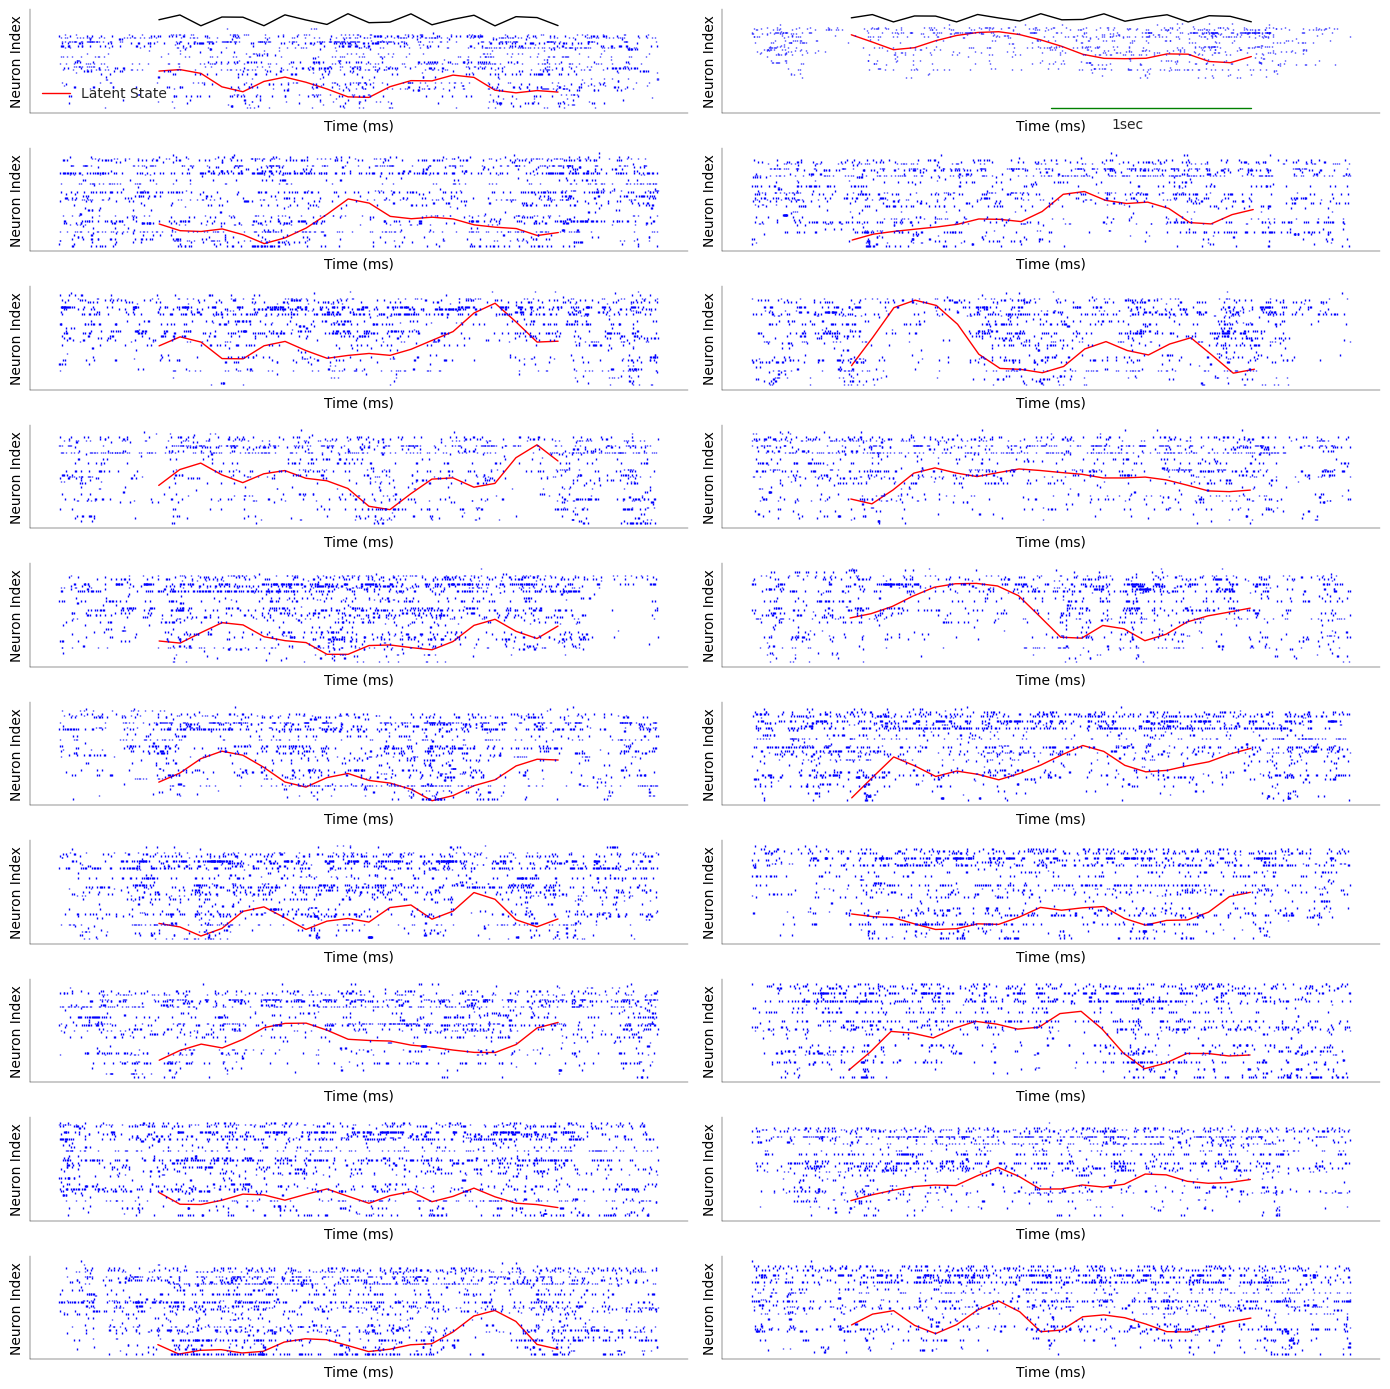

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# calculating required parameters from optimParams
neuron_weights = fitBatch.optimParams["C"].flatten()
sorted_indices = np.argsort(neuron_weights)

spike_times = [trial["spike_time"] for trial in data.data[:20]]

latent_state = np.array(fitBatch.infRes["post_mean"][:20])  # first 20 trials


# Ensure latent_state has the correct shape (num_trials, num_time_points) if needed
if latent_state.ndim == 3:
    latent_state = latent_state[:, 0, :]  # Select the first latent dimension

# # Normalize latent state
# latent_state = (latent_state - np.min(latent_state)) / (
#     np.max(latent_state) - np.min(latent_state)
# )

# # Scale latent state to match raster plot y-axis range (0 to 50)
# scaled_latent_state = latent_state * 50  # Adjust the scaling factor if necessary

# Assuming ts should correspond to the bin centers
num_time_points = latent_state.shape[1]
ts = np.linspace(0, 2000, num_time_points)
xa = 0.15
xs = 0.7 * xa * np.sin(ts / 1000 * 3.4 * 2 * np.pi) + xa

fig, axs = plt.subplots(10, 2, figsize=(14, 14))

with sns.axes_style("ticks"):
    for ntrial, ax in enumerate(axs.flat):
        # ------------------------
        # plot latent state (1 pt)
        # ------------------------
        ax.plot(ts, scaled_latent_state[ntrial], label="Latent State", color="red")

        # ----------------------------------
        # plot raster for each neuron (1 pt)
        # ----------------------------------
        for i, neuron_idx in enumerate(sorted_indices):
            spike_times_trial = spike_times[ntrial][neuron_idx]
            ax.vlines(spike_times_trial, i + 0.5, i + 1.5, color="blue")

        if ntrial == 0:
            ax.legend()
        if ntrial == 1:
            ax.plot([1000, 2000], [-30, -30], color="green")
            ax.text(1300, -50, "1sec")
        if ntrial < 2:
            ax.plot(ts, (xs * 40) + data.ydim, color="black")

        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_ylabel("Neuron Index")
        ax.set_xlabel("Time (ms)")

plt.tight_layout()
plt.show()

## Task 4. Visualization of covariance matrix.

Plot (a) the covariance matrix of the observed data as well as its approximation using (b) one and (c) five latent variable(s). Use the analytical solution for the covariance matrix of the approximation*. Note that the solution is essentially the mean and covariance of the [log-normal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution).

$ \mu = \exp(\frac{1}{2} \text{ diag}(CC^T)+d)$

$ \text{Cov}= \mu\otimes\mu^T \odot \exp(CC^T)+\mu\cdot \mathbb{I} - \mu\otimes\mu^T$ 

*[Krumin, M., and Shoham, S. (2009). Generation of Spike Trains with Controlled Auto- and Cross-Correlation Functions. Neural Computation 21, 1642–1664](http://www.mitpressjournals.org/doi/10.1162/neco.2009.08-08-847).

*Grading: 3 pts*

In [56]:
# insert your code here

# --------------------------------------------------------------
# Complete the analytical solution for the covariance matrix of
# the approximation using the provide equations (2 pts)
# --------------------------------------------------------------


def cov(fit: engine.PPGPFAfit) -> np.ndarray:
    # Extract parameters from the fit object
    if "C" in fit.optimParams:
        C = fit.optimParams["C"]  # Loading matrix
    else:
        raise AttributeError(
            "PPGPFAfit object does not have attribute 'C' in optimParams"
        )

    if "d" in fit.optimParams:
        d = fit.optimParams["d"]  # Intercept
    else:
        raise AttributeError(
            "PPGPFAfit object does not have attribute 'd' in optimParams"
        )

    # Compute the mean (mu) and covariance (C) using the provided formula
    diag_CCt = np.diag(C @ C.T)
    mu = np.exp(0.5 * diag_CCt + d)
    cov_approx = np.outer(mu, mu) * np.exp(C @ C.T) + np.diag(mu) - np.outer(mu, mu)

    return cov_approx, mu


# --------------------------------------------------------------
# Plot the covariance matrix (1 pt) of
# (1) the observed data
# (2) its approximation using 1 latent variable
# (3) its approximation using 5 latent variable
# --------------------------------------------------------------

obs_corr = np.cov(data.all_raster)
opt_r1, mu1 = cov(xval.fits[0])
opt_r5, mu5 = cov(xval.fits[4])

print(mu1)
print(opt_r1)

[1.59148097 2.44114513 2.19405063 2.61705422 0.5983279  0.11455028
 1.09680781 0.28905415 0.13772563 0.39956904 0.3070551  0.48385564
 1.67816729 1.50073815 6.61813802 0.09889104 0.07667074 0.10439341
 0.04144938 0.0665913  0.11184118 1.676657   0.39083283 0.16416912
 0.34574229 0.44184921 1.40395514 0.47955442 1.18986054 0.76513627
 0.26443624 0.52756124 0.13482252 0.09697377 1.30338523 0.13947133
 2.21245453 1.60385454 1.08448725 0.06318595 0.78332176 3.68673198
 1.6939404  0.15941726 1.97669633 0.08570523 4.67987832 1.34306747
 0.34781398 0.13368041 0.72167411 0.06144613 0.110159   1.0119765
 0.38240035]
[[1.60108274e+00 2.20514460e-02 1.03015751e-02 ... 7.13532810e-04
  8.89072604e-03 1.92718544e-03]
 [2.20514460e-02 2.49181212e+00 2.36536892e-02 ... 1.63881345e-03
  2.04271851e-02 4.42529293e-03]
 [1.03015751e-02 2.36536892e-02 2.20510404e+00 ... 7.65513271e-04
  9.53688392e-03 2.06778609e-03]
 ...
 [7.13532810e-04 1.63881345e-03 7.65513271e-04 ... 1.10212022e-01
  6.60734830e-04 

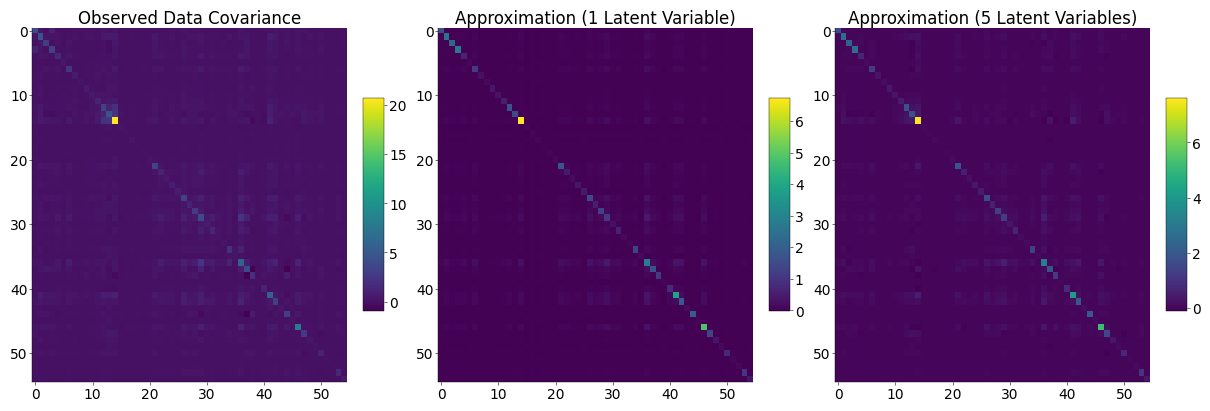

In [58]:
# Create the figure and axes
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot 1: Observed Data Covariance
im0 = axs[0].imshow(
    obs_corr,
    cmap="viridis",
    aspect="auto",
    vmin=np.min(obs_corr),
    vmax=np.max(obs_corr),
)
axs[0].set_title("Observed Data Covariance")
fig.colorbar(im0, ax=axs[0], location="right", shrink=0.6, aspect=10)

# Plot 2: Approximation (1 Latent Variable)
im1 = axs[1].imshow(
    opt_r1, cmap="viridis", aspect="auto", vmin=np.min(opt_r1), vmax=np.max(opt_r1)
)
axs[1].set_title("Approximation (1 Latent Variable)")
fig.colorbar(im1, ax=axs[1], location="right", shrink=0.6, aspect=10)

# Plot 3: Approximation (5 Latent Variables)
im2 = axs[2].imshow(
    opt_r5, cmap="viridis", aspect="auto", vmin=np.min(opt_r5), vmax=np.max(opt_r5)
)
axs[2].set_title("Approximation (5 Latent Variables)")
fig.colorbar(im2, ax=axs[2], location="right", shrink=0.6, aspect=10)